In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [4]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_pr = np.vstack([create_predictdand_data(file)['pr'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = 86400 * Y_test["pr"].mean('member')

In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

### Prepare model

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 13517098.275022108
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.89170749e+01,  1.04133523e+01, -3.42008577e+01,  3.05127733e+01,
       -7.27416197e-12, -2.11263252e-12, -2.72860865e-12,  7.54389489e-12,
       -5.58919359e-11, -1.50731888e-11, -1.89197784e+01,  1.99979250e+01,
       -6.30670565e+00, -2.49929808e+00,  2.38534180e+01, -1.58285586e+00,
       -1.75502704e+01, -1.85369078e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 237
      nit: 184
   status: 0
  success: True
        x: array([ 3.51713303e+00, -1.75953487e-01, -2.28635109e-01, -4.24202708e+00,
        2.08876410e-01,  5.96765921e-01,  5.78095445e-01, -1.81467012e+00,
       -5.58208882e+00, -3.33889961e+01,  3.42233637e-01, -3.07428431e+00,
       -3.82046776e+00, -3.27623882e-02,  6.16429024e+00,  7.30276569e-02,
       -5.53748824e-01,  6.50339205e-02])

### Predict on testing set

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [12]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr_truth[-20:].mean(dim='time'), posterior_pr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.4127016678387534
RMSE at 2100: 0.5800644775831284
RMSE 2045-2055: 0.5002032304426342
RMSE 2090-2100: 0.5325694200773677
RMSE 2050-2100: 0.5344113921950697
RMSE average last 20y: 0.18364825766618012


[Text(0.5, 1.0, 'Difference')]

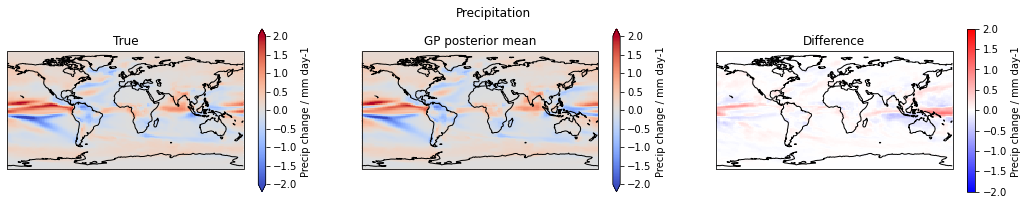

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- CO2 (0.53)
- SO2 (1.21)
- Significant internal variability (0.44)

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.06503392]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.6090354089646841
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,3.5463853963099248
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.014276026906490264
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.5853496949177268
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,3.157499051996571e-15
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.80302917, 1.03540104, 1.02340014..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.7303274907433362
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.87883359, 0.04518625, 0.02168081..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.4541235499820479


In [18]:
# Save predictions
posterior_pr_data.to_netcdf('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
posterior_pr_std_data.to_netcdf('climatebench-gp-posterior-std-pr-test-2019-2100.nc')